---
title: SuchTree, with working examples
subtitle: Worked examples illustrating some basic applications of SuchTree. This file is available as a Jupyter Notebook in the project repository under docs/examples.
icon: material/notebook-outline
---

# SuchTree

and python packages :

* `SuchTree`
* `pandas`
* `cython`
* `scipy`
* `numpy`
* `matplotlib`
* `seaborn`
* `fastcluster`
* `dendropy`

and obviously you'll want `jupyter` installed so you can run the notebook server. The
Internet is full of opinions about how to set up your python environment. You
should find one that works for you, but [this guide is as good as any](https://medium.com/@henriquebastos/the-definitive-guide-to-setup-my-python-workspace-628d68552e14) to get you started.

I'm going to start off by loading the required packages and suppressing some warnings
that [should be fixed](https://github.com/mwaskom/seaborn/issues/1392) in the next
stable release of `seaborn`.

I'm going to assume that you are running this notebook out of a local copy of the 
[SuchTree repository](https://github.com/ryneches/SuchTree/) for any local file paths.

In [19]:
%config InlineBackend.figure_format='retina'

from SuchTree import SuchTree, SuchLinkedTrees
from numpy import zeros, array
import seaborn
import pandas
import toytree
import random
import warnings

from scipy.cluster.hierarchy import ClusterWarning

warnings.simplefilter( 'ignore', UserWarning )
warnings.simplefilter( 'ignore', FutureWarning )

Let's have a look at some example data. Here is a tree of cichlid fishes
from my dissertation :

In [2]:
tree = toytree.tree( '../../data/bigtrees/host.tree' )

canvas, axes, mark = tree.draw( tree_style='d', tip_labels_align=True )

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="539.152px" height="331.84px" viewBox="0 0 539.152 331.84" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t756986dbdc814f2c80d7242d752e85d7"> Tropheus_moorii Lobochilotes_labiatus Tanganicodus_irsacae Cyprichromis_coloratus Haplotaxodon_microlepis Perissodus_microlepis Plecodus_straeleni Xenotilapia_flavipinnis Triglachromis_otostigma Reganochromis_calliurus Trematochromis_benthicola Lepidiolamprologus_profundicola Neolamprologus_buescheri Chalinochromis_brichardi

Loading tree data into `SuchTree` is pretty simple -- just give it a path
to a valid Newick file.

In [3]:
T = SuchTree( '../../data/bigtrees/host.tree' )

The `SuchTree` object has a dictionary called `leaves` that maps leaf names onto their
node ids. We'll make extensive use of this as we put the utility through its paces.

In [4]:
T.leaves

{'Tropheus_moorii': 0,
 'Lobochilotes_labiatus': 2,
 'Tanganicodus_irsacae': 4,
 'Cyprichromis_coloratus': 6,
 'Haplotaxodon_microlepis': 8,
 'Perissodus_microlepis': 10,
 'Plecodus_straeleni': 12,
 'Xenotilapia_flavipinnis': 14,
 'Triglachromis_otostigma': 16,
 'Reganochromis_calliurus': 18,
 'Trematochromis_benthicola': 20,
 'Lepidiolamprologus_profundicola': 22,
 'Neolamprologus_buescheri': 24,
 'Chalinochromis_brichardi': 26}

### Calculating distances

`SuchTree` has two ways to calculate distances; one pair a time, or
in batches. Batches are more efficient because it does each calculation without 
the interpreter's overhead.

Here's how to measure distances one at a time :

In [5]:
a = random.choice( list( T.leafs.values() ) )
b = random.choice( list( T.leafs.values() ) )

d = T.distance( a, b )

print( 'taxon 1  : %d' % a )
print( 'taxon 2  : %d' % b )
print( 'distance : %f' % d )

taxon 1  : 10
taxon 2  : 14
distance : 0.329240


The `distance()` function will accept either node ids (which are integers),
or taxon names (which are strings).

In [6]:
a = random.choice( list( T.leafs.keys() ) )
b = random.choice( list( T.leafs.keys() ) )

d = T.distance( a, b )

print( 'taxon 1  : %s' % a )
print( 'taxon 2  : %s' % b )
print( 'distance : %f' % d )

taxon 1  : Neolamprologus_buescheri
taxon 2  : Xenotilapia_flavipinnis
distance : 0.368439


You can loop over all of the distances one at a time to construct a distance matrix...

In [10]:
D1 = zeros( ( len(T.leaves),len(T.leaves) ) )
for i,a in enumerate(  T.leafs.values() ) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

Let's look at the distance matrix using a nice `seaborn` clustermap plot.

It's worth noting that `seaborn` is using scipy's `cluster.hierarchy` functions to build
those dendrograms from the distance matrix. They aren't going to have exactly the same
topology as the input tree, which was build with [RAxML](https://github.com/stamatak/standard-RAxML).

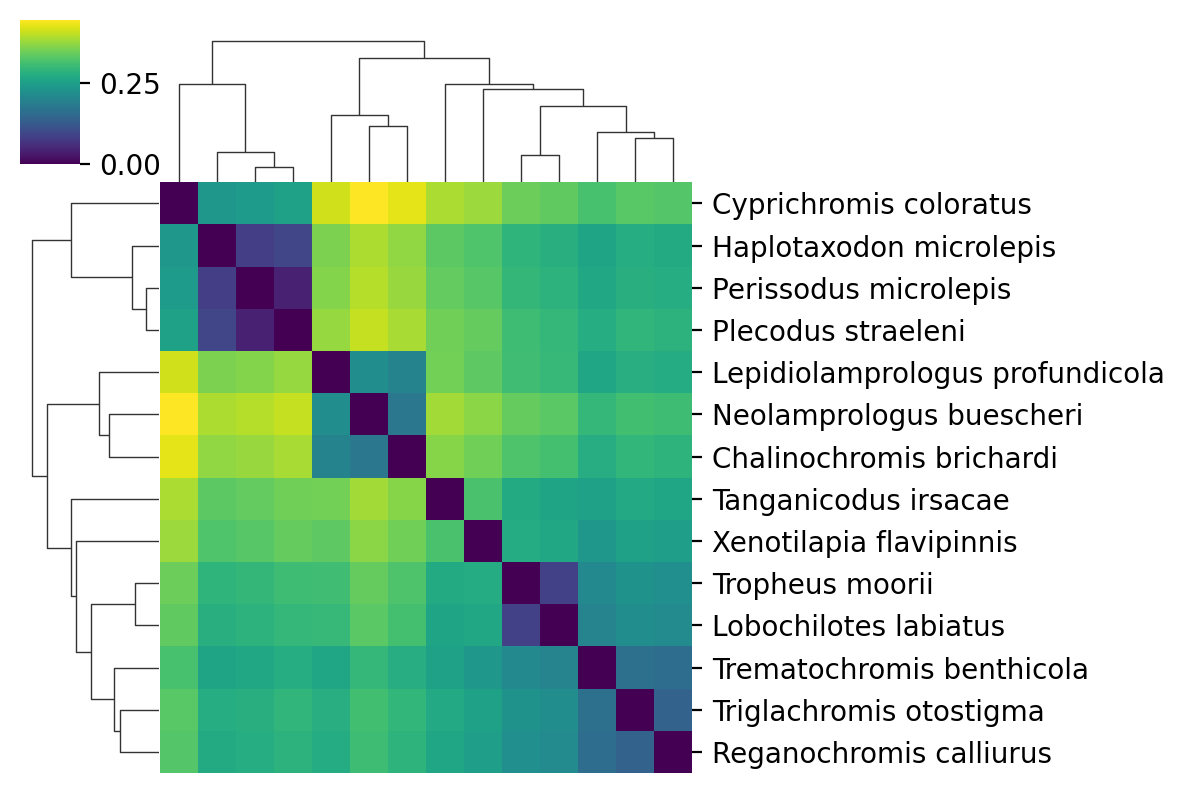

In [17]:
df = pandas.DataFrame( D1, index=[ i.replace('_',' ') for i in T.leaves.keys() ] )
seaborn.clustermap( df, xticklabels=False, cmap='viridis', figsize=(6,4) )

To calculate the distances in a batch, we can use the `distances()` function,
which takes an $n \times 2$ array of node ids (make sure your array is representing
them as integers).

In [20]:
D2_list = []
for i,a in enumerate(T.leaves.values()) :
    for j,b in enumerate( T.leaves.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )

print( D2_array.shape )
print( D2_array[:5] )

(196, 2)
[[0 0]
 [0 2]
 [0 4]
 [0 6]
 [0 8]]


In [21]:
D2 = T.distances( D2_array )

D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

We should get the same distance matrix and clustermap as before.

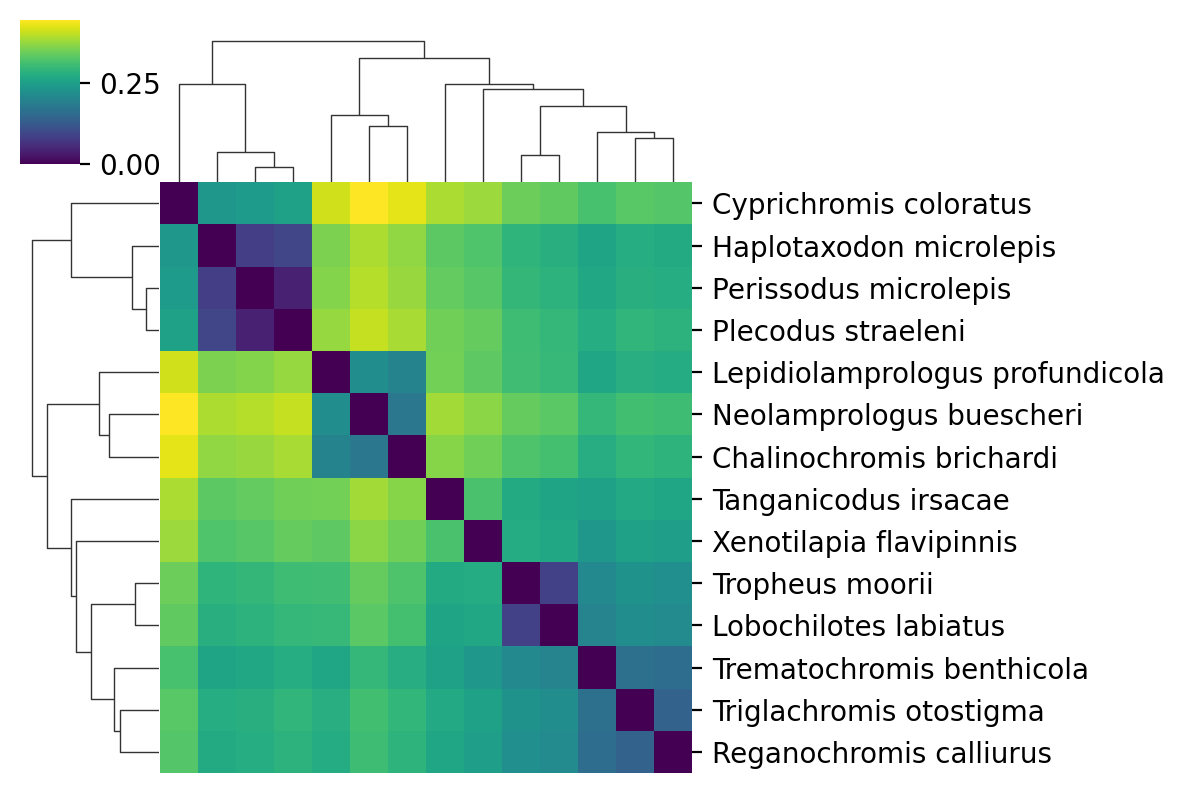

In [22]:
df = pandas.DataFrame( D2, index=[ i.replace('_',' ') for i in T.leaves.keys() ] )
seaborn.clustermap( df, xticklabels=False, cmap='viridis', figsize=(6,4) )

If you want to use taxon names instead, `distances_by_name()` accepts an $n \times 2$ list
of tuples of taxon names, and looks up the node ids for you.

### Loading data from URLs

SuchTree can also import data from the internets. Here is the distance matrix for 
the penguins, from the [Global Phylogeny of Birds](http://birdtree.org/) (I've
copied some of their data into a Gist post because their data repository forbids
programatic queries).

In [24]:
T3 = SuchTree( 'https://data.vertlife.org/birdtree/PatchClade/Stage2/set10/Spheniscidae.tre' )

D3_list = []
for i,a in enumerate(T3.leafs.values()) :
    for j,b in enumerate( T3.leafs.values() ) :
        D3_list.append( ( a, b ) )
D3_array = array( D3_list )
D3 = T3.distances( D3_array )
D3 = D3.reshape( ( len(T3.leafs), len(T3.leafs) ) )

df = pandas.DataFrame( D3, index=[ i.replace('_',' ') for i in T3.leafs.keys() ] )
seaborn.clustermap( df, xticklabels=False, cmap='viridis', figsize=(6,6) )

FileNotFoundError: [Errno 2] No such file or directory: 'https://data.vertlife.org/birdtree/PatchClade/Stage2/set10/Spheniscidae.tre'

### Comparing the topologies of two large trees

So far, we haven't done anything you couldn't do with other phylogenetics packages. 
`SuchTree` really shines when you have to do a lot of distance calculations on very
large trees.

Here, we use `SuchTree` to compare the topology of a two trees containing the taxa
but constructed with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`neighbor joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree, and the distances compared.

In [13]:
T1 = SuchTree( 'https://git.io/flbcM' )
T2 = SuchTree( 'https://git.io/flbcH' )

print( 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) ) )
print( 'nodes : %d, leafs : %d' % ( T2.length, len(T2.leafs) ) )

nodes : 108653, leafs : 54327
nodes : 108653, leafs : 54327


In [14]:
N = 1000000

v = list( T1.leafs.keys() )

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )
    
%time D1, D2 = T1.distances_by_name( pairs ), T2.distances_by_name( pairs )

CPU times: user 15.6 s, sys: 43.2 ms, total: 15.6 s
Wall time: 15.6 s


The `distances()` function, which uses node ids rather than taxa names,
would be a little bit faster. However, because the trees have different topologies,
the taxa have different node ids in each tree. `SuchTree`'s `distances_by_name()`
function untangles the leaf name to leaf node id mappings for you.

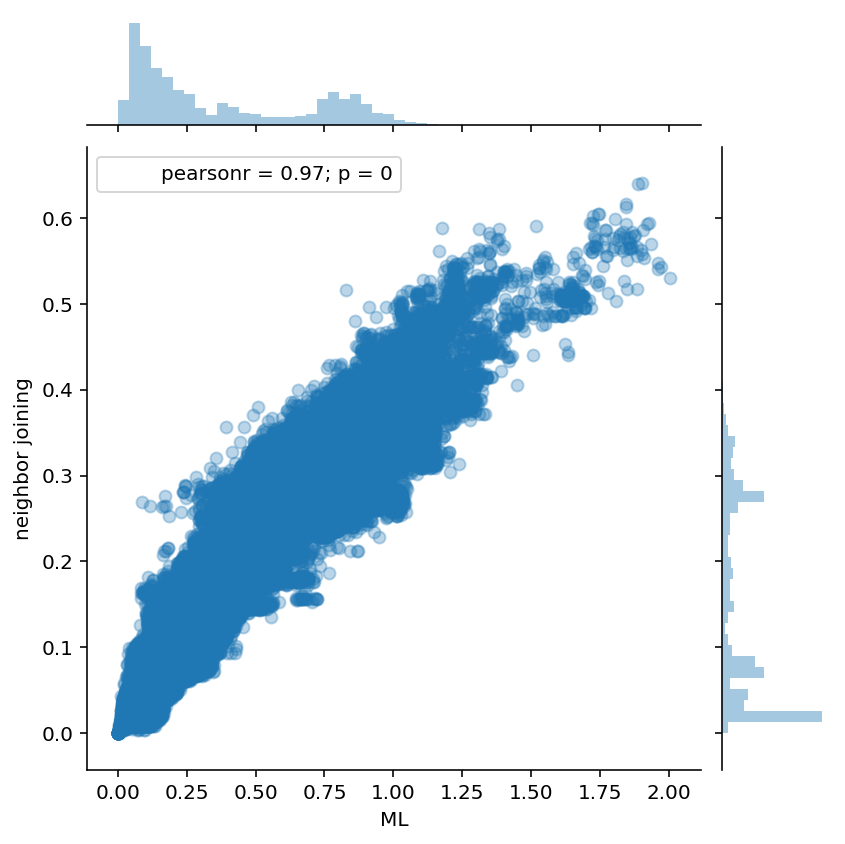

In [15]:
df = pandas.DataFrame( { 'ML' : D1, 'neighbor joining' : D2 } )

seaborn.jointplot( 'ML', 'neighbor joining', data=df, alpha=0.3, size=6 )

In [16]:
from scipy.stats import spearmanr, kendalltau, pearsonr

print( 'Spearman\'s rs : %0.3f' % spearmanr(  D1, D2 )[0] )
print( 'Kendall\'s tau : %0.3f' % kendalltau( D1, D2 )[0] )
print( 'Pearson\'s r   : %0.3f' % pearsonr(   D1, D2 )[0] )

Spearman's rs : 0.961
Kendall's tau : 0.824
Pearson's r   : 0.969


### Running with multiple threads

Another advantage of `SuchTree`'s support for performing batches of distance 
calculations is that these calculations can run outside of Python's 
[global interpreter lock](https://lbolla.info/blog/2013/12/23/python-threads-cython-gil).
This makes it possible to parallelize with [Threads](https://docs.python.org/2/library/threading.html).
Python's `Thread` has less overhead than the
[multiprocessing](https://docs.python.org/2/library/multiprocessing.html) package's
`Process`, and `Thread` objects can access the same memory. 

`SuchTree` intentionally does not allow the user to alter trees once they are created,
and so distance calculations are always thread safe. This makes it possible to use only 
*one* instance of a tree for all threads, which ought to give you the best chance of
keeping it within L3 cache.

First, let's create a Cython function that calls `SuchTree` outside of the GIL.

In [17]:
%load_ext Cython

In [18]:
%%cython
import cython

def correlation( double[:] x, double[:] y ) :
    return _correlation( x, y )

@cython.boundscheck(False)
cdef double _correlation( double[:] x, double[:] y ) nogil :
    cdef int n = x.shape[0]
    cdef int i = 0
    cdef double r = 0.0
    cdef double xbar = 0.0
    cdef double ybar = 0.0
    cdef double sx = 0.0
    cdef double sy = 0.0

    for i in xrange(n) :
        xbar += x[i]
        ybar += y[i]
    xbar /= n
    ybar /= n
    
    # compute standard deviation of x and y
    for i in xrange(n) :
        sx += (x[i] - xbar) * (x[i] - xbar)
        sy += (y[i] - ybar) * (y[i] - ybar)
        
    sx = ( sx / n )**(0.5)
    sy = ( sy / n )**(0.5)
    
    # compute r, the correlation coefficient between the two arrays
    for i in xrange(n) :
        r += (((x[i] - xbar)/sx) * ((y[i] - ybar)/sy));
    r /= (n);
    return r

Let's set up two queues, one for uncompleted tasks, which we'll call `work_q`,
and one for finished results, which we'll call `done_q`. The worker threads will
pop tasks from the `work_q`, do some work, and push the results into the `done_q`.

Let's also push sentinels at the end of the `work_q` so the workers have a convenient
way to know when to shut down.

In [19]:
from threading import Thread
from queue import Queue

n = 4  # number of threads
m = 12 # number of work units

work_q = Queue()
done_q = Queue()

v = list( T1.leafs.keys() )

print( 'building work blocks...' )
for i in range( m ) :
    pairs = []
    for i in range( 100000 ) :
        pairs.append( ( T1.leafs[ random.choice( v ) ],
                        T2.leafs[ random.choice( v ) ] ) )
    work_q.put( array( pairs, dtype=int ) )

for i in range( n ) :
    work_q.put( 'STOP' ) # sentinel elements, one for each worker

building work blocks...


The worker process takes the two queues as arguments, and returns `True`
when it completes successfully.

Note that we're not using `distances_by_name()` because it requires a call
to Python's dictionary object, which requires the GIL. Instead, we have
looked up the node id for each taxon when we created the tasks we pushed onto
`work_q`.

In [20]:
def worker( work_q, done_q ) :
    print( 'starting worker...' )
    for task in iter( work_q.get, 'STOP' ) :
        D1 = T1.distances( task )
        D2 = T2.distances( task )
        r = correlation( D1, D2 )
        done_q.put( r )
    print( 'stopping worker...' )
    return True

Now we can set up our thread pool, run it and print the results the threads
pushed onto `done_q`.

In [21]:
threads = []

for i in range( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

for r in iter( done_q.get, 'STOP' ) :
    print( r )

starting worker...
starting worker...
starting worker...
starting worker...
stopping worker...
stopping worker...
stopping worker...
stopping worker...
0.7858568333588076
0.7826590873988822
0.7844420298785083
0.7838968592880762
0.7832616169597755
0.7810781477882289
0.7823715835475968
0.7832743632827825
0.7862756657001954
0.7851411483753257
0.7828403864806949
0.7833013061598763


Threaded algorithms are difficult to implement, and this is a very minimalist approach.
It's really only good enough to demonstrate that you can call `SuchTree` from your worker
threads without tripping the interpreter lock.

If you need this capability, you will probably want to study the 
[documentation](https://docs.python.org/3/library/threading.html) carefully.